In [1]:
import torch
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import japanize_matplotlib
import torch.nn as nn
import torch.optim as optim
import numpy as np

### 1 データの取得

In [2]:
import torch.utils
import torch.utils.data

data_path = '../data/p1ch7'

trainset = datasets.CIFAR10(data_path,
                            train=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                # transforms.Normalize(())
                                ]),
                            download=False)
testset = datasets.CIFAR10(data_path, train=False, transform=transforms.ToTensor(), download=False)


学習データ画像の平均と標準偏差を計算

In [3]:
imgs = torch.stack([img_t for img_t, _ in trainset], dim=3)
print(imgs.shape)
print(imgs.view(3, -1).shape)
print(imgs.view(3, -1).mean(dim=1)) # 行方向に平均
print(imgs.view(3, -1).std(dim=1)) # 列方向に標準偏差を計算

torch.Size([3, 32, 32, 50000])
torch.Size([3, 51200000])
tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


テストデータ画像の平均と標準偏差を計算

In [4]:
imgs = torch.stack([img_t for img_t, _ in testset], dim=3)
print(imgs.view(3, -1).mean(dim=1))
print(imgs.view(3, -1).std(dim=1))

tensor([0.4942, 0.4851, 0.4504])
tensor([0.2467, 0.2429, 0.2616])


画像を正規化(標準化)してデータを取得

In [5]:
trainset = datasets.CIFAR10(data_path,
                            download=False,
                            train=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.4914, 0.4822, 0.4465),
                                    (0.2470, 0.2435, 0.2616)
                                )
                            ]))

testset = datasets.CIFAR10(data_path,
                            download=False,
                            train=False,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.4942, 0.4851, 0.4504),
                                    (0.2467, 0.2429, 0.2616)
                                )
                            ]))



飛行機と鳥のデータのみを抽出

In [6]:
labels = ["airplane", "bird"]
label_map = {0:0, 2: 1}

cifar2 = [(img_t, label_map[label])
          for img_t, label in trainset
          if label in label_map.keys()]

cifar2_val = [
    (img_t, label_map[label])
    for img_t, label in testset
    if label in label_map.keys()
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


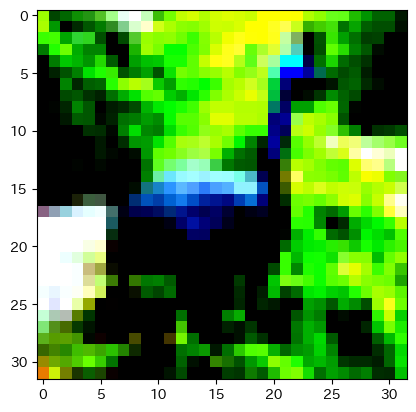

In [7]:
img = cifar2[0][0]
plt.imshow(img.permute(1, 2, 0))
plt.show()

### 2. モデルの構築

In [47]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
    # nn.Softmax(dim=1)
)


### 3. 学習

バッチサイズごとにデータをロード

In [48]:
epochs = 10
batch_size = 100
lr = 1e-2
loss_fn = nn.NLLLoss()
# loss_fn = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr)
trainloader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar2_val, batch_size=batch_size, shuffle=False)

In [49]:
correct = 0
total = 0

for epoch in range(1, epochs + 1):
    for imgs, labels in trainloader:
        imgs = imgs.view(batch_size, -1)
        output = model(imgs)
        loss = loss_fn(output, torch.tensor(labels))
        
        # MSEを使った損失計算
        # tmp = torch.zeros((batch_size, 2))
        # for row, l in zip(tmp, labels):
        #     row[l] = 1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, index = torch.max(output, dim=1)
        correct += torch.tensor([labels[i] == index[i] for i in range(0, len(labels))]).sum()
        total += batch_size
    print(f'Epoch{epoch}: Loss: {loss}')

print(f'Accuracy: {(correct / total)*100} %')

/tmp/ipykernel_464924/454496518.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(output, torch.tensor(labels))


Epoch1: Loss: 0.42796260118484497
Epoch2: Loss: 0.4793960154056549
Epoch3: Loss: 0.37070369720458984
Epoch4: Loss: 0.44917184114456177
Epoch5: Loss: 0.3891844153404236
Epoch6: Loss: 0.2979045808315277
Epoch7: Loss: 0.33027324080467224
Epoch8: Loss: 0.3647318184375763
Epoch9: Loss: 0.3821655213832855
Epoch10: Loss: 0.4260682761669159
Accuracy: 80.44300079345703 %


### 4. テスト

In [50]:
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in testloader:
        imgs = imgs.view(batch_size, -1)
        output = model(imgs)
        
        _, index = torch.max(output, dim=1)
        
        correct += int((index == labels).sum())
        total += batch_size

print(f'Accuracy: {(correct / total) *100} %')

Accuracy: 82.05 %
